In [1]:
import os
import pandas as pd
import scanpy as sc
import anndata as ad
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=300, facecolor="white")
sc.set_figure_params(fontsize=12)
sc.settings.vector_friendly = False

scanpy==1.10.3 anndata==0.10.9 umap==0.5.7 numpy==2.0.2 scipy==1.13.1 pandas==2.2.3 scikit-learn==1.5.2 statsmodels==0.14.4 igraph==0.11.8 pynndescent==0.5.13


# Create Cytotoxicity and Tolerance Module Scores

## Load and Prep Data

In [3]:
adata = sc.read_h5ad("Final_Notebooks/Final_Objects/PBMCs_anno_manual_refined_renamed.h5ad")
adata

AnnData object with n_obs × n_vars = 120853 × 1631
    obs: 'ExperimentID', 'ConditionID', 'n_genes', 'n_counts', 'doublet_score', 'predicted_doublet', 'Donor', 'Condition', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'predicted_doublet_0.2', 'predicted_doublet_0.25', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'Annotations_broad', 'Broad_Manual_Anno', 'Broad_Manual_Anno_renamed'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', '

In [4]:
adata = adata.raw.to_adata()

## Gene lists

In [5]:
#GSEA Cytotoxicity GO Term Gene List
GOBP_POSITIVE_REGULATION_OF_T_CELL_MEDIATED_CYTOTOXICITY =[
    "B2M", "CD1A", "CD1B", "CD1C", "CD1D", "CD1E", "CYRIB", "FADD", "HFE", 
    #"HLA-A", "HLA-B", "HLA-C", "HLA-DRA", "HLA-DRB1", "HLA-E", "HLA-F", "HLA-G", "HLA-H", 
    "IL12A", "IL12B", "IL12RB1", "IL23A", "IL23R", "MICA", "MICB", "MR1", "NECTIN2", 
    "P2RX7", "PTPRC", "PVR", "RAET1E", "RAET1G", "RAET1L", "SLC22A13", "STX7", "TAP2", 
    "ULBP1", "ULBP2", "ULBP3", "XCL1"
]

# Manual list of cyto genes
cytotoxicity_genes = [
    "GZMB",   # Granzyme B 
    "PRF1",   # Perforin 1
    "GNLY",   # Granulysin
    "NKG7",   # Natural Killer Cell Granule Protein 7
    "KLRD1",  # Killer Cell Lectin Like Receptor D1 (CD94)
    "KLRK1",  # Killer Cell Lectin Like Receptor K1 (NKG2D)
    "FASLG",  # Fas Ligand
    "IFNG",   # Interferon Gamma
    "TNF",    # Tumor Necrosis Factor
    "CCL5",   # Chemokine (C-C Motif) Ligand 5
    "LTA",    # Lymphotoxin Alpha (TNF Superfamily, Member 1)
    "EOMES",  # Eomesodermin
    "TBX21"   # T-Box Transcription Factor TBX21 (T-Bet)
]

##Merge manual and GO lists
Total_cyto = list(set(
                      GOBP_POSITIVE_REGULATION_OF_T_CELL_MEDIATED_CYTOTOXICITY+
                      cytotoxicity_genes
                    ))

In [6]:
#GO terms for T cell Tolerance from GSEA
GOBP_POSITIVE_REGULATION_OF_T_CELL_TOLERANCE_INDUCTION=["CBLB","CD3E","FOXP3",
                                                        "HLA-G","IDO1","ITCH","LILRB2","LILRB4","TGFBR2"]


GOBP_T_CELL_TOLERANCE_INDUCTION = ["AIRE", "CBLB", "CD3E", "CLC", "FOXP3", 
                                   "HLA-B", 
                                  "HLA-G", "ICOS", "IDO1", "IL2RA", "ITCH", "LILRB2", 
                                  "LILRB4", "PHLPP1", "TGFBR2"]
#Manual Tolerance genes
Tolerance = [
    "FOXP3",    # Transcription factor critical for regulatory T cell function
    "IL10",     # Anti-inflammatory cytokine
    "TGFB1",    # Transforming growth factor-beta, involved in immune regulation
    "CTLA4",    # Cytotoxic T-lymphocyte-associated protein 4, involved in downregulation of immune responses
    "PDCD1",    # Programmed cell death protein 1 (PD-1), involved in the inhibition of T cell activity
    "IL2RA",    # IL-2 receptor alpha chain, highly expressed on regulatory T cells
    "ICOS",     # Inducible T-cell costimulator, involved in T cell activation and regulation
    "TNFRSF18", # Tumor necrosis factor receptor superfamily member 18, also known as GITR
    "ENTPD1",   # Ectonucleotidase involved in the regulation of inflammation
    "NT5E"      # Ectonucleotidase that produces anti-inflammatory adenosine
    "CD274",    # Programmed death-ligand 1 (PD-L1)
    "HAVCR2",   # Hepatitis A virus cellular receptor 2, also known as TIM-3
    "BTLA",     # B and T lymphocyte attenuator
    "CD101",    # Immune cell surface glycoprotein
    "CD127",    # Interleukin-7 receptor alpha chain, low expression on Tregs
    "IKZF2",    # Ikaros family zinc finger 2, also known as Helios
    "CCR4",     # C-C chemokine receptor type 4
    "ICOSLG",   # Inducible T-cell costimulator ligand
    "TNFRSF4",  # Tumor necrosis factor receptor superfamily member 4, also known as OX40
    "FAS",      # Fas cell surface death receptor
]

#Merge manual and GO term lists
Total_tol = list(set(
                     GOBP_T_CELL_TOLERANCE_INDUCTION+
                     GOBP_POSITIVE_REGULATION_OF_T_CELL_TOLERANCE_INDUCTION+
                    Tolerance
                    ))
Total_tol = Total_tol

## Cytotoxicity analysis

### Find variable genes of only the cell types of interest ###

In [7]:
# Subset for CD8+ Effector T Cells
adata_cyto_CD8_temp = adata[adata.obs['Broad_Manual_Anno_renamed'] == 'CD8+ Effector T Cells']

# Subset for NK Cells
adata_cyto_NK_temp = adata[adata.obs['Broad_Manual_Anno_renamed'] == 'NK Cells']


In [8]:
# Identify HVGs in CD8+ Effector T Cells
sc.pp.highly_variable_genes(
    adata_cyto_CD8_temp,
    min_mean=0.1,
    max_mean=5,
    min_disp=0.2,
    max_disp=30
)

# Identify HVGs in NK Cells
sc.pp.highly_variable_genes(
    adata_cyto_NK_temp,
    min_mean=0.1,
    max_mean=5,
    min_disp=0.2,
    max_disp=30
)

# Subset to highly variable genes and store raw
adata_cyto_CD8_temp.raw = adata_cyto_CD8_temp
adata_cyto_CD8_temp = adata_cyto_CD8_temp[:, adata_cyto_CD8_temp.var.highly_variable]

adata_cyto_NK_temp.raw = adata_cyto_NK_temp
adata_cyto_NK_temp = adata_cyto_NK_temp[:, adata_cyto_NK_temp.var.highly_variable]

# Extract HVG names from both subsets
hvg_CD8 = adata_cyto_CD8_temp.var_names.tolist()
hvg_NK = adata_cyto_NK_temp.var_names.tolist()

# Combine unique HVGs from both cell types
combined_hvgs = list(set(hvg_CD8 + hvg_NK))

# Intersect with cytotoxic gene list (Total_cyto)
common_genes = list(set(Total_cyto) & set(combined_hvgs))
genes_not_in_common = list(set(Total_cyto) - set(combined_hvgs))

# Return shared cytotoxic genes that are also HVGs
np.array(common_genes)

extracting highly variable genes
    finished (0:00:00)


/home/as3562/miniconda3/envs/PBMC_env/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:696: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
extracting highly variable genes
    finished (0:00:00)


/home/as3562/miniconda3/envs/PBMC_env/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:696: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


array(['CCL5', 'PTPRC', 'STX7', 'TBX21', 'LTA', 'P2RX7', 'TNF', 'NKG7',
       'GZMB', 'PRF1', 'GNLY', 'KLRK1', 'FASLG', 'EOMES', 'KLRD1', 'MR1',
       'XCL1', 'IFNG'], dtype='<U5')

### Visualize the Cytotoxicity Genes

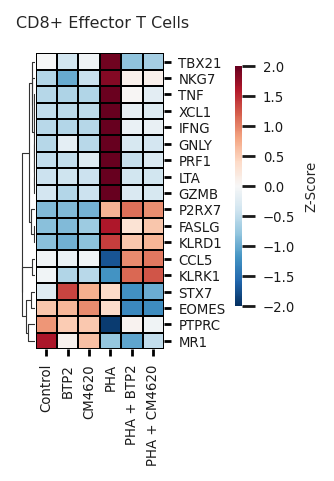

In [9]:
sns.set(style="white")
sc.set_figure_params(fontsize=6)

# Use the intersected HVG cytotoxic genes
gene_list = common_genes

# Subset the data for CD8+ Effector T Cells
cd8_effector_subset = adata[adata.obs['Broad_Manual_Anno_renamed'] == 'CD8+ Effector T Cells']

# Define ordered experimental conditions
ordered_conditions = ['Control', 'BTP2', 'CM4620', 
                      'PHA', 'PHA + BTP2', 'PHA + CM4620']

# Initialize DataFrame to store average gene expression per condition
avg_expression = pd.DataFrame(index=gene_list, columns=ordered_conditions)

# Compute mean expression per gene for each condition
for condition in ordered_conditions:
    condition_subset = cd8_effector_subset[cd8_effector_subset.obs['Condition'] == condition]
    condition_data = condition_subset[:, gene_list].X

    # Convert to dense if sparse
    if not isinstance(condition_data, np.ndarray):
        condition_data = condition_data.toarray()

    avg_expression[condition] = condition_data.mean(axis=0)

# Z-score normalization (per gene)
normalized_expression = (
    avg_expression - avg_expression.mean(axis=1).values[:, None]
) / avg_expression.std(axis=1).values[:, None]

# Plot heatmap using seaborn clustermap
g = sns.clustermap(
    normalized_expression,
    cmap="RdBu_r",
    col_cluster=False,
    annot=False,
    cbar_kws={'label': 'Z-Score'},
    figsize=(1.5, 3),
    metric="euclidean",
    method="average",
    dendrogram_ratio=(0.1, 0.1),
    cbar_pos=(0.95, 0.375, 0.03, 0.5),
    linecolor='black',
    linewidths=0.1,
    vmin=-2,
    vmax=2,
    xticklabels=ordered_conditions
)

# Format axis ticks
g.ax_heatmap.tick_params(axis='x', which='both', bottom=True, top=False, length=3, color='black')
g.ax_heatmap.tick_params(axis='y', which='both', bottom=True, top=False, length=3, color='black')

# Add title
g.fig.suptitle('CD8+ Effector T Cells', x=0.4)

# Save figure
plt.savefig('Final_Notebooks/Figures/Marker_Prog/cyto_gene_heatmap_CD8.pdf', bbox_inches='tight', dpi=300)
plt.show()


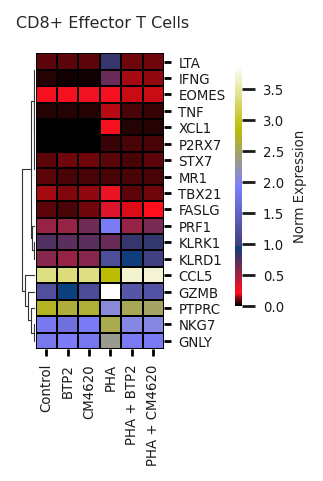

In [10]:
sc.set_figure_params(fontsize=6)

# Define gene list
gene_list = common_genes

# Subset to CD8+ Effector T Cells
cd8_effector_subset = adata[adata.obs['Broad_Manual_Anno_renamed'] == 'CD8+ Effector T Cells']

# Define condition order
ordered_conditions = ['Control', 'BTP2', 'CM4620', 
                      'PHA', 'PHA + BTP2', 'PHA + CM4620']

# Initialize dataframe to store average expression values
avg_expression = pd.DataFrame(index=gene_list, columns=ordered_conditions)

# Compute average expression per gene per condition
for condition in ordered_conditions:
    condition_subset = cd8_effector_subset[cd8_effector_subset.obs['Condition'] == condition]
    condition_data = condition_subset[:, gene_list].X
    
    # Ensure dense matrix
    if not isinstance(condition_data, np.ndarray):
        condition_data = condition_data.toarray()
    
    avg_expression[condition] = condition_data.mean(axis=0)

# Plot clustermap (non-z-scored expression)
g = sns.clustermap(
    avg_expression.astype(float),
    cmap="gist_stern",  # Alternatives: 'gist_ncar', 'viridis', etc.
    annot=False,
    cbar_kws={'label': 'Norm Expression'},
    col_cluster=False,
    figsize=(1.5, 3),
    metric="euclidean",
    method="average",
    dendrogram_ratio=(0.1, 0.1),
    cbar_pos=(0.95, 0.375, 0.03, 0.5),
    linecolor='black',
    linewidths=0.1,
    vmin=0
)

# Customize axes
g.ax_heatmap.tick_params(axis='x', which='both', bottom=True, top=False, length=3, color='black')
g.ax_heatmap.tick_params(axis='y', which='both', bottom=True, top=False, length=3, color='black')

# Add title
g.fig.suptitle('CD8+ Effector T Cells', x=0.4)

# Save to file
plt.savefig('Final_Notebooks/Figures/Marker_Prog/cyto_norm_gene_heatmap_CD8.pdf', bbox_inches='tight', dpi=300)
plt.show()


/home/as3562/miniconda3/envs/PBMC_env/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:900: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


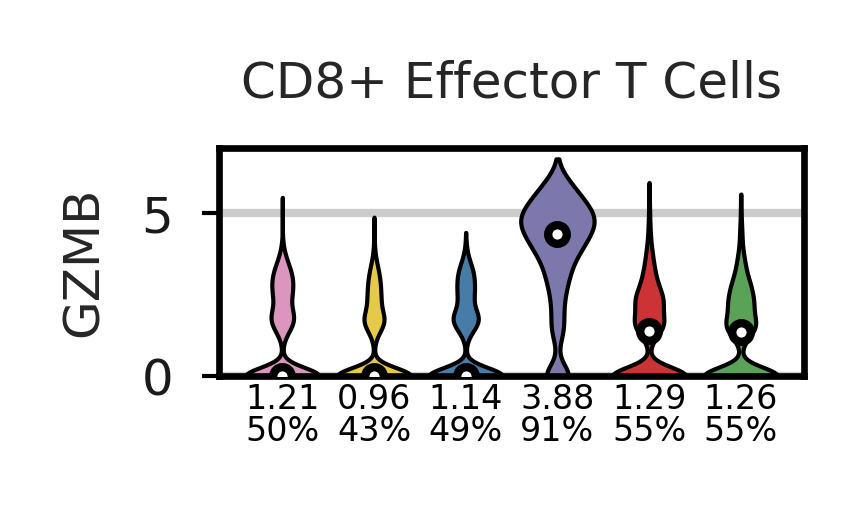

/home/as3562/miniconda3/envs/PBMC_env/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:900: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


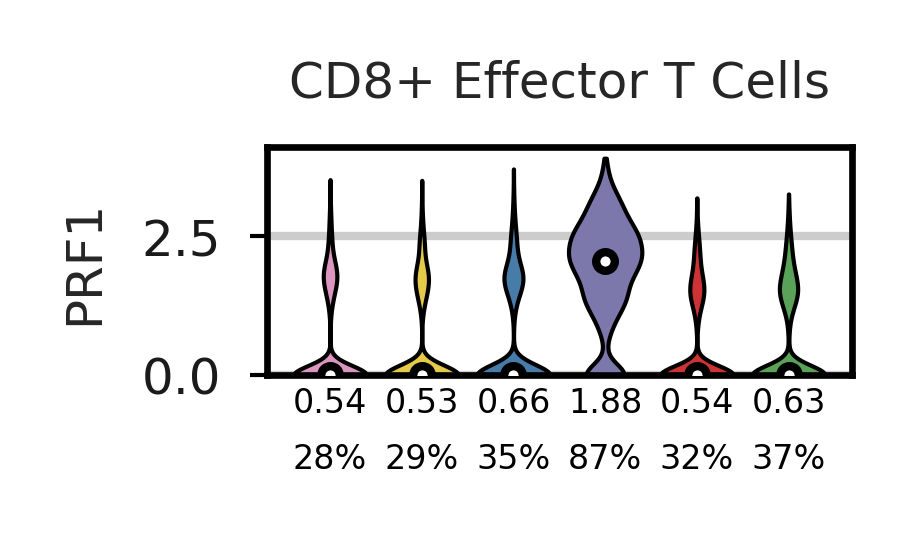

In [11]:
from matplotlib.collections import PolyCollection
sc.set_figure_params(fontsize=6)

GOI = ['GZMB', 'PRF1']
palette_cust = ['#e78ac3','#ffd92f','#377eb8','#7570b3','#e41a1c','#4daf4a']

subset = adata[adata.obs['Broad_Manual_Anno_renamed'] == 'CD8+ Effector T Cells']

sc.settings.set_figure_params(figsize=(1.25, 0.5), facecolor='white', dpi=300, fontsize=6)

# Create a violin plot for each gene of interest (GOI)
for gene in GOI:
    fig, ax = plt.subplots()

    sc.pl.violin(
        subset,
        keys=gene,
        jitter=False,
        stripplot=False,
        groupby='Condition',
        palette=palette_cust,
        show=False,
        ax=ax
    )
    ax.set_title('CD8+ Effector T Cells')
    ax.tick_params(axis='x', which='both', bottom=False, top=False, length=3, color='black', labelbottom=False)
    ax.set_xlabel('')
    ymax = ax.get_ylim()[1]
    ax.set_ylim(0,ymax)
    # Customize violin edges
    for collection in ax.collections:
        if isinstance(collection, PolyCollection):
            collection.set_edgecolor('black')
            collection.set_linewidth(0.5)

    ymin = ax.get_ylim()[0]
    
    conditions_ordered = subset.obs['Condition'].cat.categories

    for i, group in enumerate(conditions_ordered):
        expr = subset[subset.obs['Condition'] == group][:, gene].X.toarray().flatten()
        mean_val = expr.mean()
        median_val = np.median(expr)
        non_zero_pct = (np.count_nonzero(expr) / len(expr)) * 100
    
        ax.scatter(i, median_val, color='white', edgecolor='black', s=5, zorder=3, label='Median' if i == 0 else "")
        ax.text(i, -0.2, f'{round(mean_val, 2):.2f}', color='black', fontsize=4, ha='center', va='top', zorder=4)
        ax.text(i, -1.2, f'{round(non_zero_pct):.0f}%', color='black', fontsize=4, ha='center', va='top', zorder=4)
    
    plt.tick_params(axis='y', which='both', left=True, right=False, length=2, color='black', width=0.5)
    
    plt.savefig(f'Final_Notebooks/Figures/Marker_Prog/{gene}_gene_violin_CD8.pdf', bbox_inches='tight', dpi=300)
    plt.show()


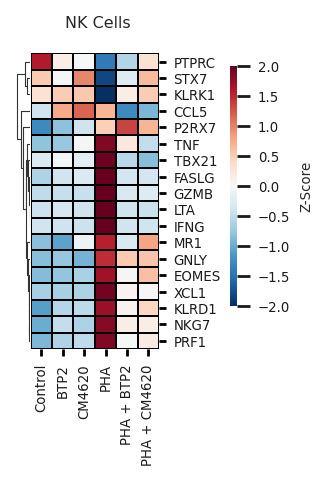

In [12]:

sc.set_figure_params(fontsize=6)

gene_list = common_genes

# Subset the data for CD8+ Effector T Cells
NK_subset = adata[adata.obs['Broad_Manual_Anno_renamed'] == 'NK Cells']

# Initialize the ordered conditions
ordered_conditions = ['Control', 'BTP2', 'CM4620', 
                      'PHA', 'PHA + BTP2', 'PHA + CM4620']

# Initialize a DataFrame to store the average expression values by condition
avg_expression = pd.DataFrame(index=gene_list, columns=ordered_conditions)

# Calculate the average expression for each gene split by condition
for condition in ordered_conditions:
    # Subset the data for each condition
    condition_subset = NK_subset[NK_subset.obs['Condition'] == condition]
    
    # Convert to dense matrix if sparse
    condition_data = condition_subset[:, gene_list].X
    if not isinstance(condition_data, np.ndarray):
        condition_data = condition_data.toarray()  # Convert sparse matrix to dense matrix if needed
    
    # Calculate the mean expression for each gene and store it in the dataframe
    avg_expression[condition] = condition_data.mean(axis=0)

# Normalize (z-score) the expression values for each gene
normalized_expression = (avg_expression - avg_expression.mean(axis=1).values[:, None]) / avg_expression.std(axis=1).values[:, None]

# Create a clustermap using seaborn
g = sns.clustermap(normalized_expression, cmap="RdBu_r", annot=False, cbar_kws={'label': 'Z-Score'},col_cluster=False ,
               figsize=(1.5, 3), metric="euclidean", method="average",dendrogram_ratio=(0.1, 0.1),cbar_pos = (0.95,0.375,0.03,0.5),
                  linecolor='black', linewidths=0.1,vmin=-2,vmax=2)

g.ax_heatmap.tick_params(axis='x', which='both', bottom=True, top=False, length=3, color='black')
g.ax_heatmap.tick_params(axis='y', which='both', bottom=True, top=False, length=3, color='black')

g.fig.suptitle('NK Cells', 
               x=0.4) 
plt.savefig('Final_Notebooks/Figures/Marker_Prog/cyto_gene_heatmap_NK.pdf', bbox_inches='tight', dpi=300)

plt.show()

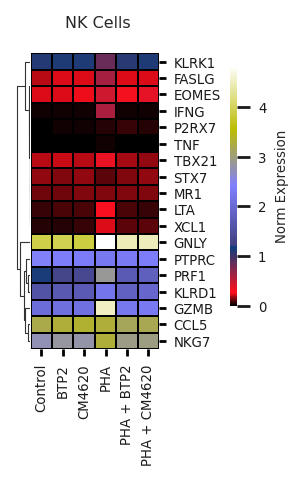

In [13]:

sc.set_figure_params(fontsize=6)

gene_list = common_genes

# Subset the data for CD8+ Effector T Cells
NK_subset = adata[adata.obs['Broad_Manual_Anno_renamed'] == 'NK Cells']

# Initialize the ordered conditions
ordered_conditions = ['Control', 'BTP2', 'CM4620', 
                      'PHA', 'PHA + BTP2', 'PHA + CM4620']

# Initialize a DataFrame to store the average expression values by condition
avg_expression = pd.DataFrame(index=gene_list, columns=ordered_conditions)

# Calculate the average expression for each gene split by condition
for condition in ordered_conditions:
    # Subset the data for each condition
    condition_subset = NK_subset[NK_subset.obs['Condition'] == condition]
    
    # Convert to dense matrix if sparse
    condition_data = condition_subset[:, gene_list].X
    if not isinstance(condition_data, np.ndarray):
        condition_data = condition_data.toarray()  # Convert sparse matrix to dense matrix if needed
    
    # Calculate the mean expression for each gene and store it in the dataframe
    avg_expression[condition] = condition_data.mean(axis=0)
    
# Create a clustermap using seaborn
g = sns.clustermap(avg_expression, cmap="gist_stern", annot=False, cbar_kws={'label': 'Norm Expression'},col_cluster=False ,
               figsize=(1.5, 3), metric="euclidean", method="average",dendrogram_ratio=(0.1, 0.1),cbar_pos = (0.95,0.375,0.03,0.5),
                  linecolor='black', linewidths=0.1,vmin=0)

g.ax_heatmap.tick_params(axis='x', which='both', bottom=True, top=False, length=3, color='black')
g.ax_heatmap.tick_params(axis='y', which='both', bottom=True, top=False, length=3, color='black')
g.fig.suptitle('NK Cells', 
               x=0.4) 
plt.savefig('Final_Notebooks/Figures/Marker_Prog/cyto_norm_gene_heatmap_NK.pdf', bbox_inches='tight', dpi=300)

plt.show()

/home/as3562/miniconda3/envs/PBMC_env/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:900: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


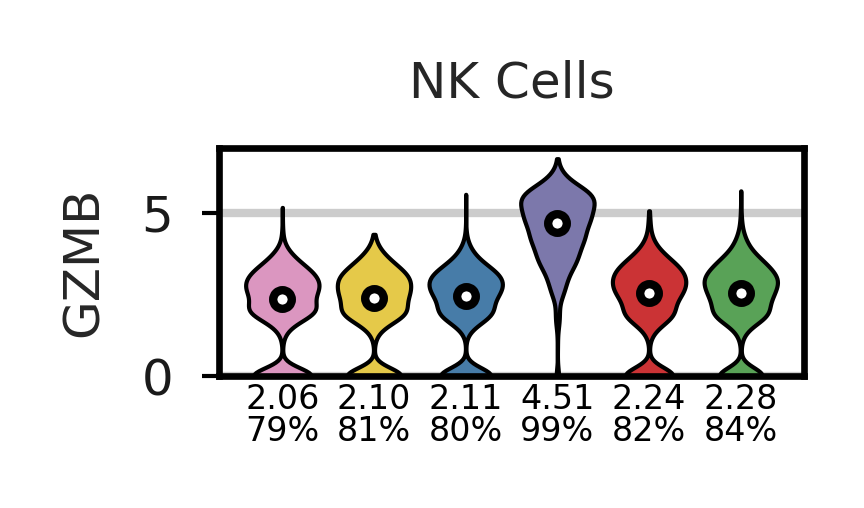

/home/as3562/miniconda3/envs/PBMC_env/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:900: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


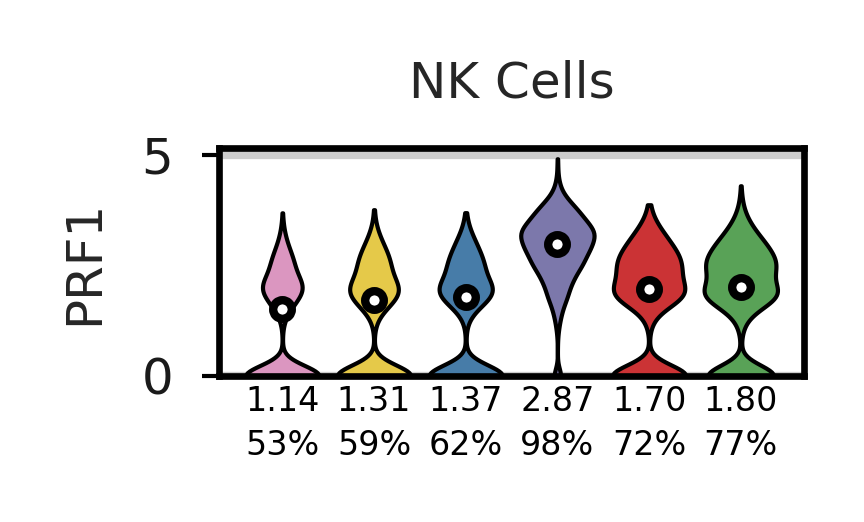

In [14]:
from matplotlib.collections import PolyCollection
sc.set_figure_params(fontsize=6)

GOI = ['GZMB','PRF1']
palette_cust = ['#e78ac3','#ffd92f','#377eb8','#7570b3','#e41a1c','#4daf4a']
subset = adata[adata.obs['Broad_Manual_Anno_renamed'] == 'NK Cells']

sc.settings.set_figure_params(figsize=(1.25, 0.5), facecolor='white', dpi=300, fontsize=6)

# Create a violin plot for each gene of interest (GOI)
for gene in GOI:
    fig, ax = plt.subplots()

    sc.pl.violin(
        subset,
        keys=gene,
        jitter=False,
        stripplot=False,
        groupby='Condition',
        palette=palette_cust,
        show=False,
        ax=ax
    )
    ax.set_title('NK Cells')
    ax.tick_params(axis='x', which='both', bottom=False, top=False, length=3, color='black', labelbottom=False)
    ax.set_xlabel('')
    ymax = ax.get_ylim()[1]
    ax.set_ylim(0,ymax)
    # Customize violin edges
    for collection in ax.collections:
        if isinstance(collection, PolyCollection):
            collection.set_edgecolor('black')
            collection.set_linewidth(0.5)

    ymin = ax.get_ylim()[0]
    
    conditions_ordered = subset.obs['Condition'].cat.categories

    for i, group in enumerate(conditions_ordered):
        expr = subset[subset.obs['Condition'] == group][:, gene].X.toarray().flatten()
        mean_val = expr.mean()
        median_val = np.median(expr)
        non_zero_pct = (np.count_nonzero(expr) / len(expr)) * 100
    
        ax.scatter(i, median_val, color='white', edgecolor='black', s=5, zorder=3, label='Median' if i == 0 else "")
        ax.text(i, -0.2, f'{round(mean_val, 2):.2f}', color='black', fontsize=4, ha='center', va='top', zorder=4)
        ax.text(i, -1.2, f'{round(non_zero_pct):.0f}%', color='black', fontsize=4, ha='center', va='top', zorder=4)
    
    plt.tick_params(axis='y', which='both', left=True, right=False, length=2, color='black', width=0.5)
        
    plt.savefig(f'Final_Notebooks/Figures/Marker_Prog/{gene}_gene_violin_NK.pdf', bbox_inches='tight', dpi=300)
    plt.show()


### Module Score for Cytotoxicity

In [15]:
markers = common_genes
name_mark = "Cytotoxicity"

In [16]:
#generate a gene module score using the cytotoxic gene list
sc.tl.score_genes(adata, markers, ctrl_size=200, gene_pool=None,
                  n_bins=25, score_name=name_mark, random_state=0, 
               copy=False, use_raw=None)

computing score 'Cytotoxicity'
    finished: added
    'Cytotoxicity', score of gene set (adata.obs).
    1796 total control genes are used. (0:00:03)


/tmp/ipykernel_3833847/2128832971.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_scores = df.groupby(['Condition', 'Broad_Manual_Anno_renamed']).mean().reset_index()


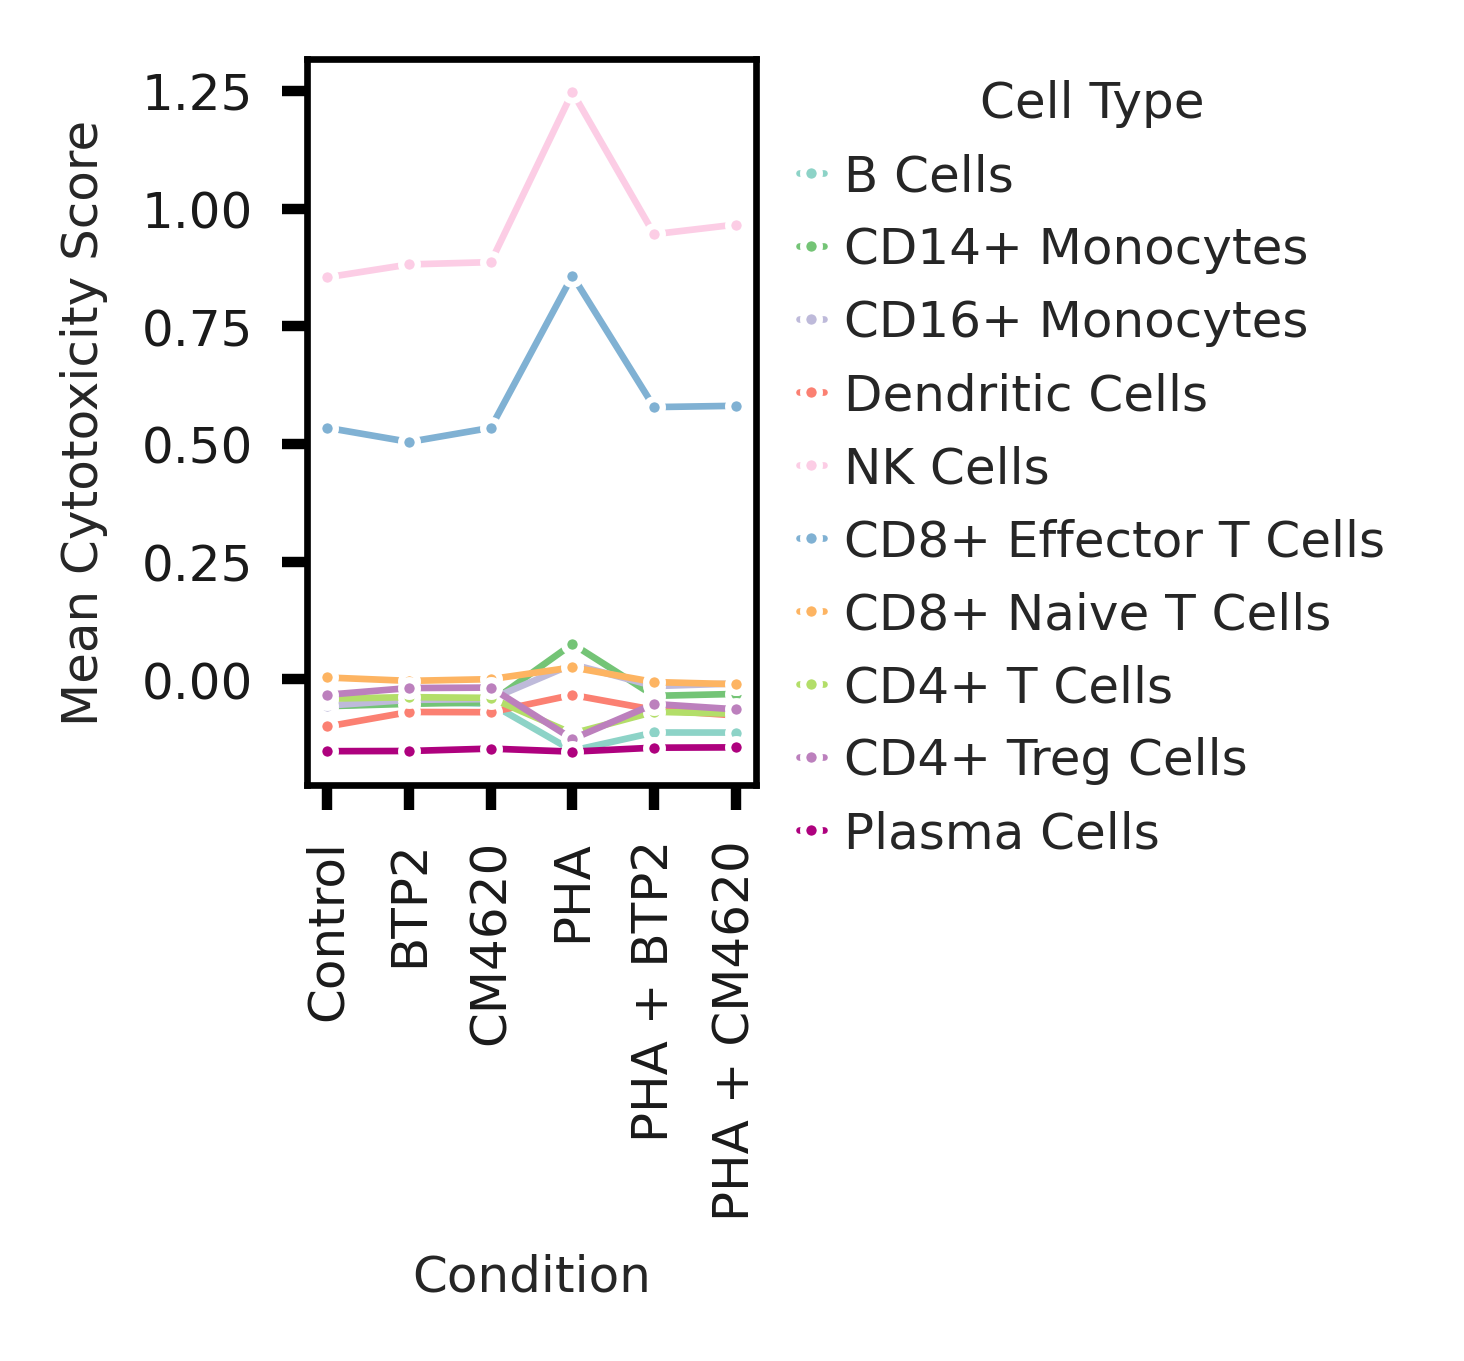

In [17]:
sns.set(style="white")
sc.set_figure_params(fontsize=6,dpi=300)

celltype_color_dict = {
    'B Cells': '#8dd3c7',
    'CD14+ Monocytes': '#74c476',
    'CD16+ Monocytes': '#bebada',
    'Dendritic Cells': '#fb8072',
    'CD8+ Effector T Cells': '#80b1d3',
    'CD8+ Naive T Cells': '#fdb462',
    'CD4+ T Cells': '#b3de69',
    'NK Cells': '#fccde5',
    'Plasma Cells': '#ae017e',
    'CD4+ Treg Cells': '#bc80bd'
}
df = adata.obs[['Condition', 'Broad_Manual_Anno_renamed', name_mark]]

# Calculate mean scores
mean_scores = df.groupby(['Condition', 'Broad_Manual_Anno_renamed']).mean().reset_index()

# Create a line plot
plt.figure(figsize=(2.5, 2.25))
sns.lineplot(data=mean_scores, x='Condition', y=name_mark, hue='Broad_Manual_Anno_renamed', marker='o', sort=True,
             palette=celltype_color_dict, linewidth=0.8,markersize=2)


plt.tick_params(axis='x', which='both', bottom=True, top=False, length=3, color='black')
plt.tick_params(axis='y', which='both', left=True, right=False, length=3, color='black')

# Add labels and title
plt.xlabel('Condition')
plt.ylabel(f'Mean {name_mark} Score')
plt.title(f'')#Mean {name_mark} Scores by Condition and Cell Type
plt.xticks(rotation=90,ha = "center")  # Rotating x labels for better readability
plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,frameon=False,fontsize=6,title_fontsize=6)
plt.grid(False)
# Show the plot
plt.tight_layout()
plt.savefig('Final_Notebooks/Figures/Marker_Prog/cyto_line_plot.pdf', bbox_inches='tight',dpi=300)
plt.show()


In [18]:
module_name = name_mark
marker_data = adata


### Generate Cohen's D metric

In [19]:
condition_palette =['#e78ac3','#ffd92f','#377eb8','#7570b3','#e41a1c','#4daf4a']


In [20]:
cell_type = 'CD8+ Effector T Cells'

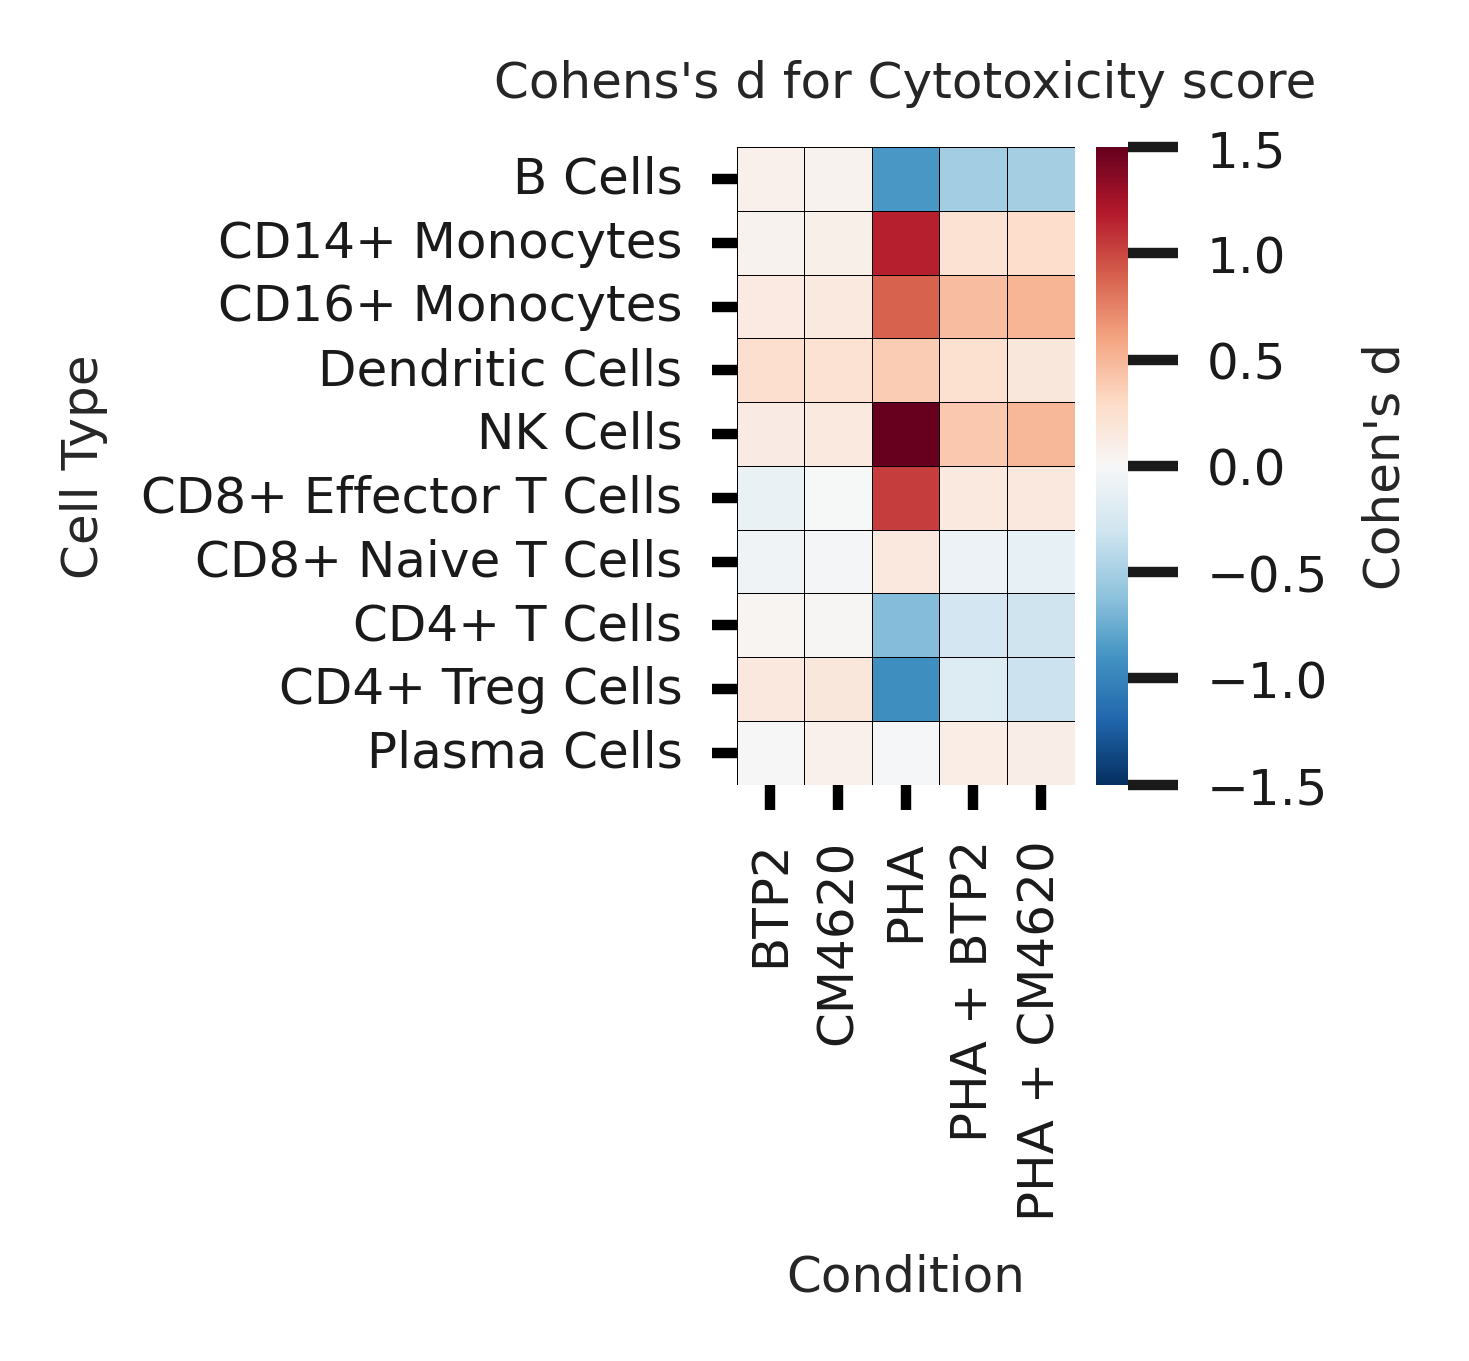

In [21]:
sns.set(style="white")
sc.set_figure_params(fontsize=6,dpi=300)

# Define a function to calculate Cohen's d
def cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    pooled_std = np.sqrt((np.var(x, ddof=1) * (nx - 1) + np.var(y, ddof=1) * (ny - 1)) / (nx + ny - 2))
    return (np.mean(x) - np.mean(y)) / pooled_std

# Get the specified order of conditions
ordered_conditions = ['BTP2', 'CM4620', 
                      'PHA', 'PHA + BTP2', 'PHA + CM4620']

# Desired order of cell types
celltype_order = ['B Cells', 'CD14+ Monocytes', 'CD16+ Monocytes', 'Dendritic Cells','NK Cells',
                  'CD8+ Effector T Cells', 'CD8+ Naive T Cells', 'CD4+ T Cells',
                    'CD4+ Treg Cells','Plasma Cells']

# Initialize a DataFrame to store Cohen's d values
cohen_d_matrix = pd.DataFrame(index=celltype_order, columns=ordered_conditions)

# Calculate Cohen's d for each cell type and condition compared to the control
control_condition = 'Control'
for cell_type in celltype_order:
    control_data = marker_data.obs[(marker_data.obs['Condition'] == control_condition) &
                                   (marker_data.obs['Broad_Manual_Anno_renamed'] == cell_type)][module_name]
    for condition in ordered_conditions:
        condition_data = marker_data.obs[(marker_data.obs['Condition'] == condition) &
                                         (marker_data.obs['Broad_Manual_Anno_renamed'] == cell_type)][module_name]
        if len(control_data) > 1 and len(condition_data) > 1:  # Ensure there is enough data to calculate Cohen's d
            cohen_d_matrix.loc[cell_type, condition] = cohens_d(condition_data, control_data)

# Plot the heatmap with adjusted scale limits
plt.figure(figsize=(2.3, 2.25))
sns.heatmap(cohen_d_matrix.astype(float), annot=False, fmt=".2f", cmap="RdBu_r", cbar_kws={'label': "Cohen's d"}, linecolor='black', linewidths=0.1, vmin=-1.5, vmax=1.5)
plt.title(f'Cohens\'s d for {module_name} score')
plt.xlabel('Condition')
plt.ylabel('Cell Type')
plt.xticks(rotation=90, ha='center')
plt.tick_params(axis='x', which='both', bottom=True, top=False, length=3, color='black')
plt.tick_params(axis='y', which='both', left=True, right=False, length=3, color='black')
plt.tight_layout()

# Save the figure
plt.savefig('Final_Notebooks/Figures/Marker_Prog/cyto_heatmap.pdf', bbox_inches='tight', dpi=300)
plt.show()  # Display the plot

## Repeat for Tolerence in CD4+ Treg Cells

In [22]:
adata_tol_temp = adata[adata.obs['Broad_Manual_Anno_renamed'].isin(['CD4+ Treg Cells'])]
adata_tol_temp.obs['Broad_Manual_Anno_renamed'].unique()

['CD4+ Treg Cells']
Categories (1, object): ['CD4+ Treg Cells']

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/as3562/miniconda3/envs/PBMC_env/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:696: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


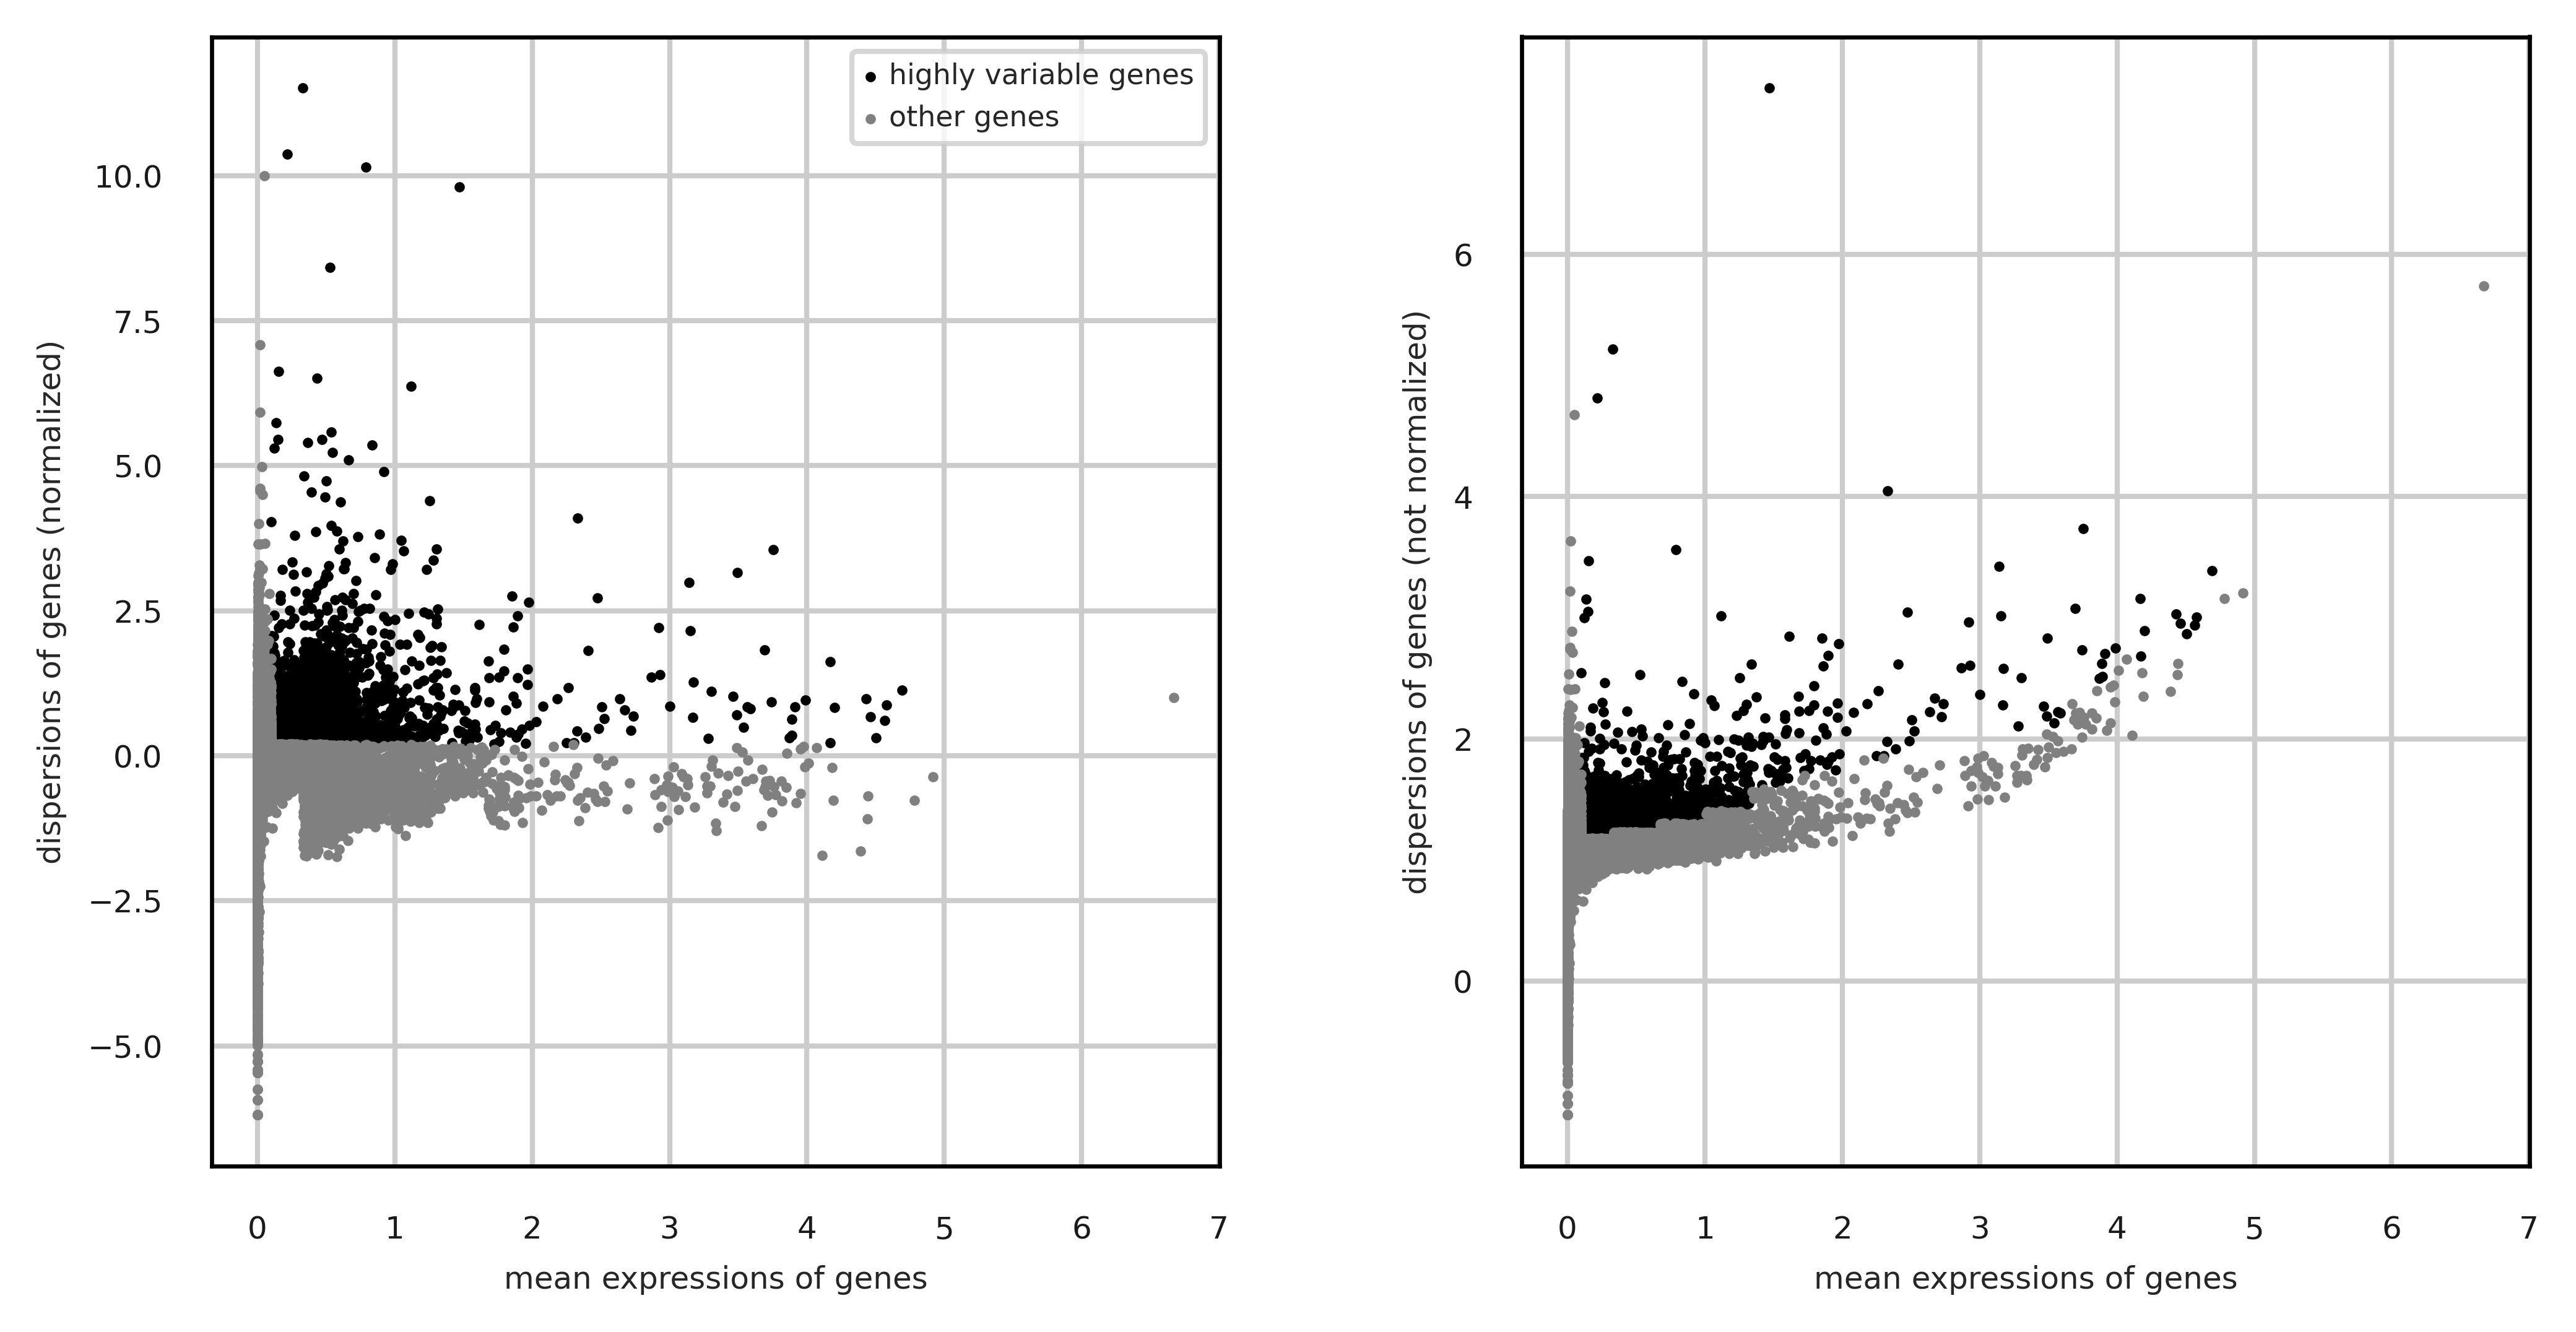

In [23]:
sc.pp.highly_variable_genes(adata_tol_temp, min_mean=0.1, min_disp=0.2,max_mean=5,max_disp=15)
sc.pl.highly_variable_genes(adata_tol_temp)


In [24]:
# Keep IL10 as a HVG even though it's lowly expressed
adata_tol_temp.var.loc['IL10', 'highly_variable'] = True
adata_tol_temp[:, 'IL10'].var

,mt,ribo,hb,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection
IL10,False,False,False,5309,0.099247,0.094625,95.902474,12859.0,9.461877,True,0.02538,1.661443,1.555937,19,False


In [25]:
adata_tol_temp.raw = adata_tol_temp
adata_tol_temp = adata_tol_temp[:, adata_tol_temp.var.highly_variable]
adata_tol_temp

View of AnnData object with n_obs × n_vars = 2507 × 3123
    obs: 'ExperimentID', 'ConditionID', 'n_genes', 'n_counts', 'doublet_score', 'predicted_doublet', 'Donor', 'Condition', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'predicted_doublet_0.2', 'predicted_doublet_0.25', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'Annotations_broad', 'Broad_Manual_Anno', 'Broad_Manual_Anno_renamed', 'Cytotoxicity'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly

In [26]:
gene_names_in_adata = adata_tol_temp.var.index.tolist()

# Find common tolerance genes
common_genes = list(set(Total_tol) & set(gene_names_in_adata))
genes_not_in_common = list(set(Total_tol) - set(gene_names_in_adata))

In [27]:
np.array(common_genes)

array(['ICOS', 'IDO1', 'TGFB1', 'TNFRSF18', 'IL10', 'FOXP3', 'TNFRSF4',
       'ITCH', 'ENTPD1', 'CBLB', 'TGFBR2', 'IKZF2', 'IL2RA', 'CCR4',
       'CTLA4', 'FAS', 'HLA-B'], dtype='<U8')

/home/as3562/miniconda3/envs/PBMC_env/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:900: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


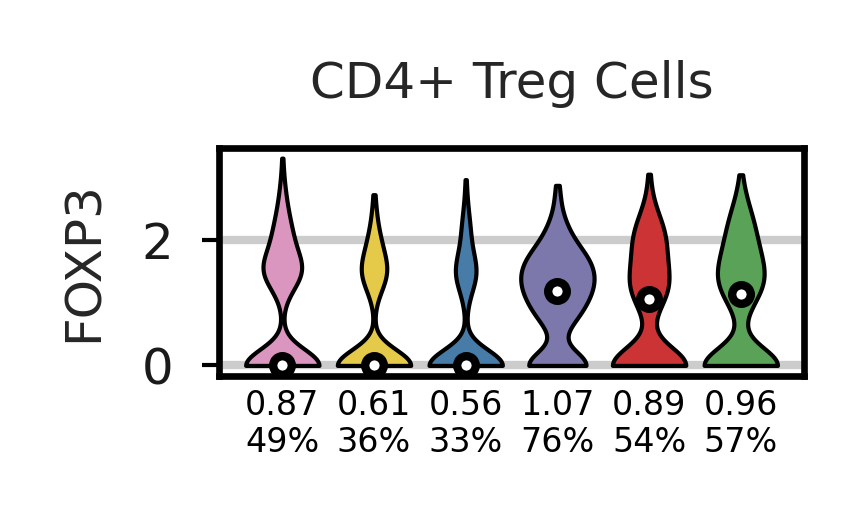

/home/as3562/miniconda3/envs/PBMC_env/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:900: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


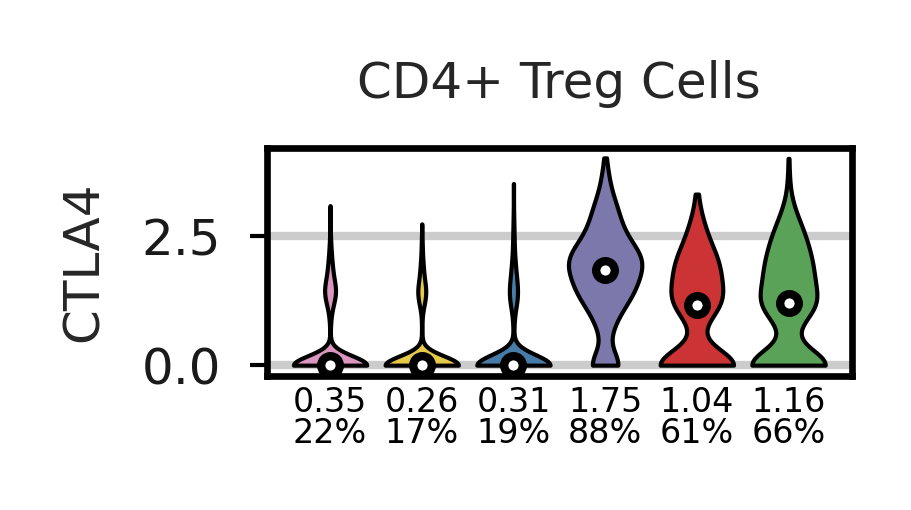

/home/as3562/miniconda3/envs/PBMC_env/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:900: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


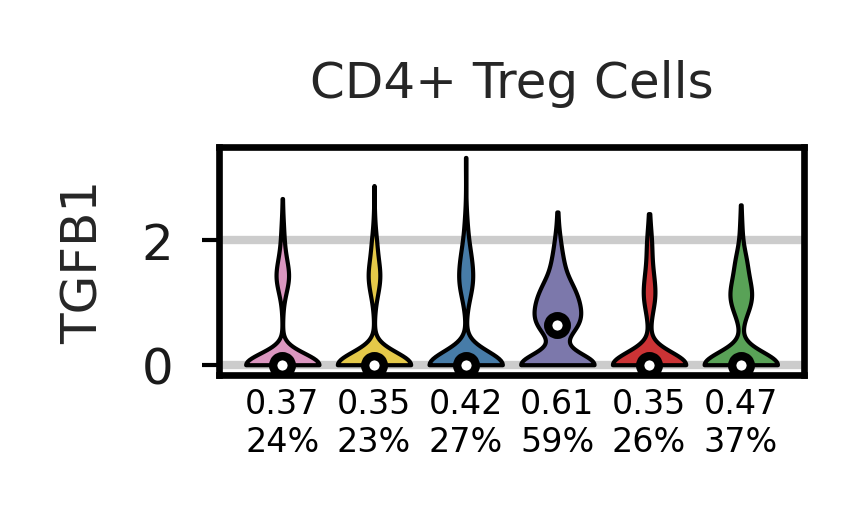

/home/as3562/miniconda3/envs/PBMC_env/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:900: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


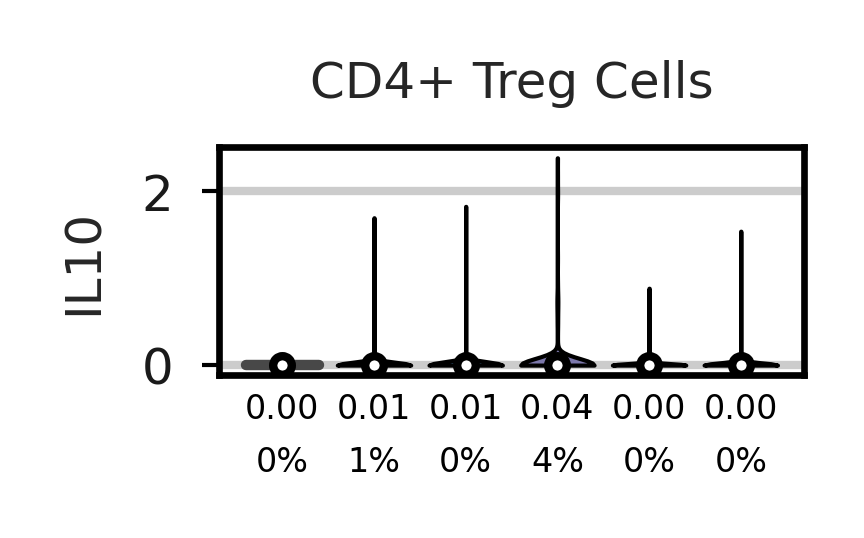

In [28]:
from matplotlib.collections import PolyCollection
sc.set_figure_params(fontsize=6)

GOI = ['FOXP3','CTLA4','TGFB1', 'IL10']
palette_cust = ['#e78ac3','#ffd92f','#377eb8','#7570b3','#e41a1c','#4daf4a']
subset = adata[adata.obs['Broad_Manual_Anno_renamed'] == 'CD4+ Treg Cells']

sc.settings.set_figure_params(figsize=(1.25, 0.5), facecolor='white', dpi=300, fontsize=6)

# Create a violin plot for each gene of interest (GOI)
for gene in GOI:
    fig, ax = plt.subplots()

    sc.pl.violin(
        subset,
        keys=gene,
        jitter=False,
        stripplot=False,
        groupby='Condition',
        palette=palette_cust,
        show=False,
        ax=ax
    )
    ax.set_title('CD4+ Treg Cells')
    ax.tick_params(axis='x', which='both', bottom=False, top=False, length=3, color='black', labelbottom=False)
    ax.set_xlabel('')

    # Customize violin edges
    for collection in ax.collections:
        if isinstance(collection, PolyCollection):
            collection.set_edgecolor('black')
            collection.set_linewidth(0.5)

    ymin = ax.get_ylim()[0]
    
    conditions_ordered = subset.obs['Condition'].cat.categories

    for i, group in enumerate(conditions_ordered):
        expr = subset[subset.obs['Condition'] == group][:, gene].X.toarray().flatten()
        mean_val = expr.mean()
        median_val = np.median(expr)
        non_zero_pct = (np.count_nonzero(expr) / len(expr)) * 100
    
        ax.scatter(i, median_val, color='white', edgecolor='black', s=5, zorder=3, label='Median' if i == 0 else "")
        ax.text(i, ymin-0.2, f'{round(mean_val, 2):.2f}', color='black', fontsize=4, ha='center', va='top', zorder=4)
        ax.text(i, ymin-0.8, f'{round(non_zero_pct):.0f}%', color='black', fontsize=4, ha='center', va='top', zorder=4)

    plt.tick_params(axis='y', which='both', left=True, right=False, length=2, color='black', width=0.5)
    
    plt.savefig(f'Final_Notebooks/Figures/Marker_Prog/{gene}_gene_violin_Treg.pdf', bbox_inches='tight', dpi=300)
    plt.show()

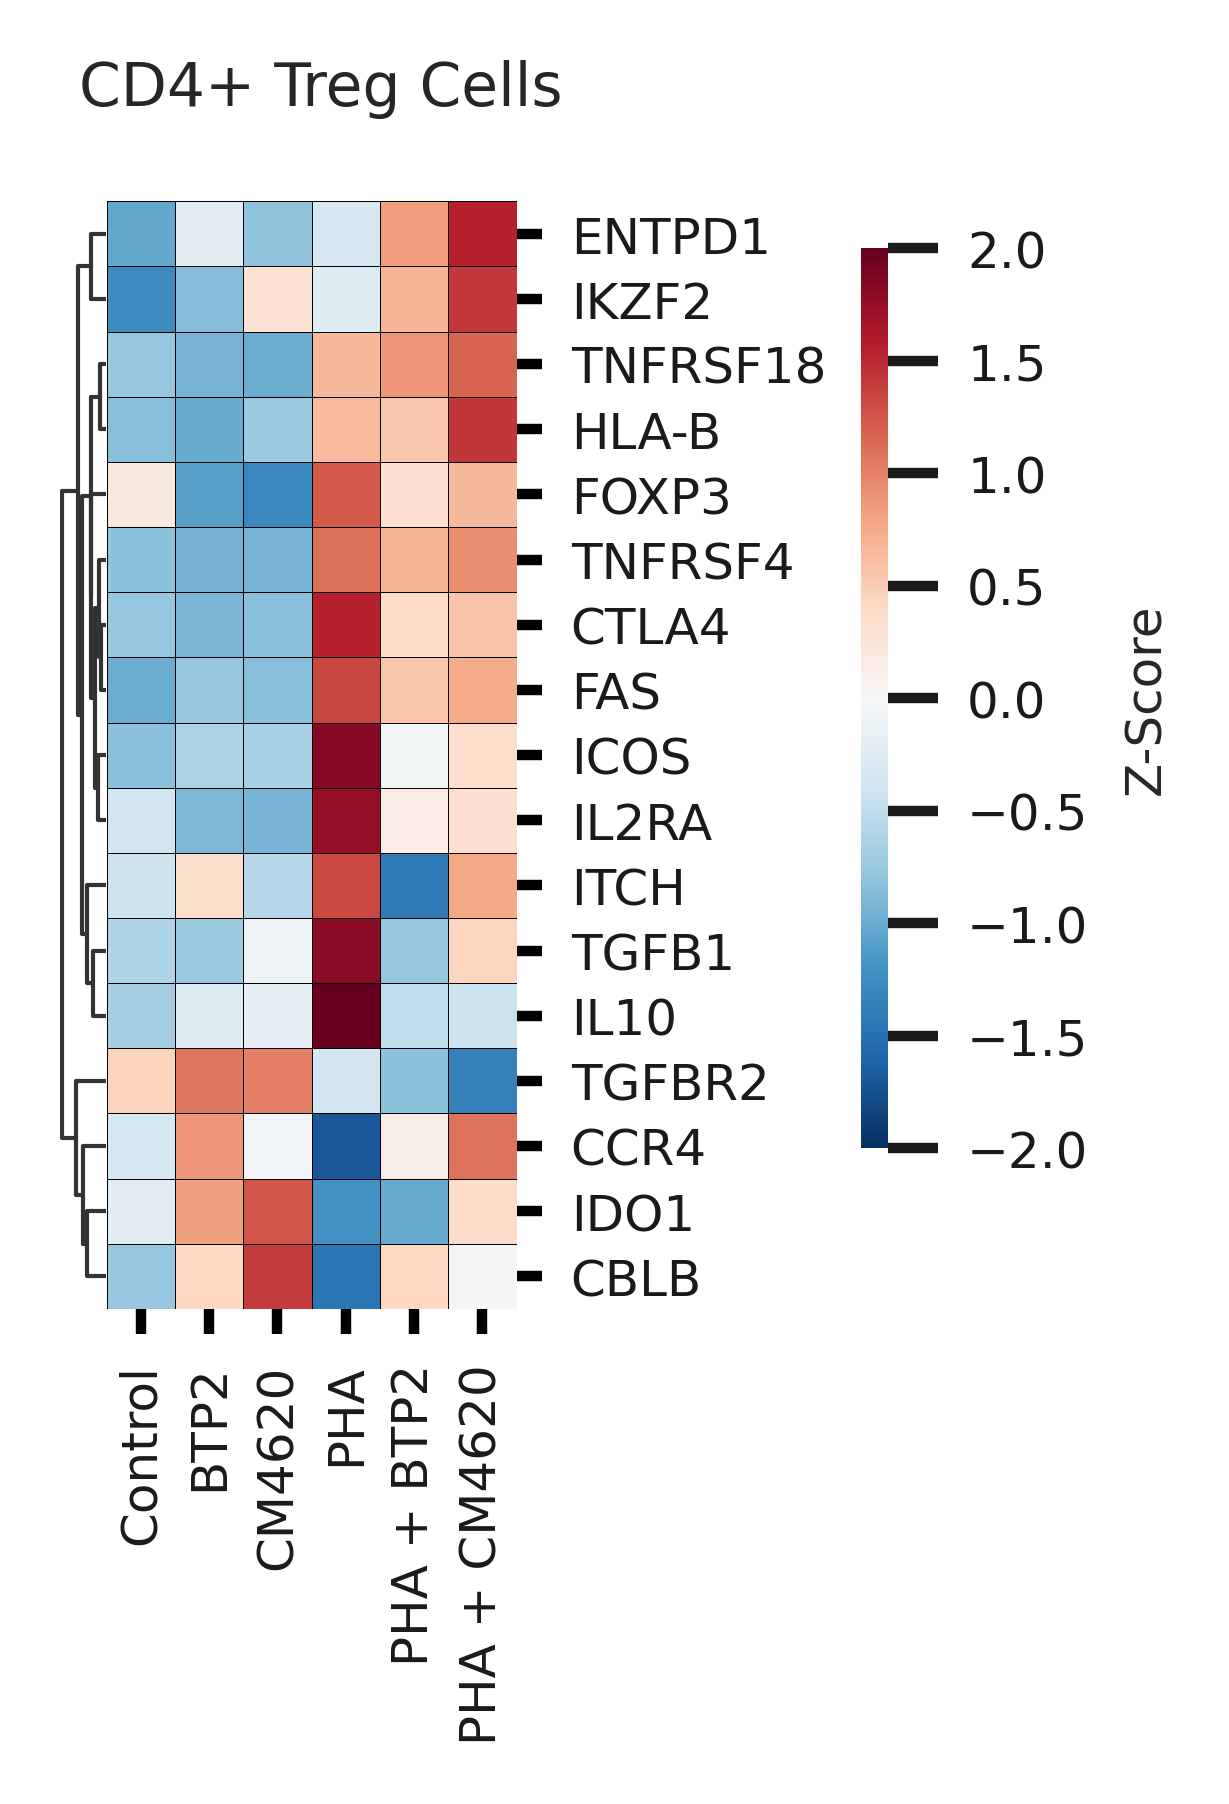

In [29]:

sc.set_figure_params(fontsize=6,dpi=300)

gene_list = common_genes

# Subset the data for CD8+ Effector T Cells
Treg_subset = adata[adata.obs['Broad_Manual_Anno_renamed'] == 'CD4+ Treg Cells']

# Initialize the ordered conditions
ordered_conditions = ['Control', 'BTP2', 'CM4620', 
                      'PHA', 'PHA + BTP2', 'PHA + CM4620']

# Initialize a DataFrame to store the average expression values by condition
avg_expression = pd.DataFrame(index=gene_list, columns=ordered_conditions)

# Calculate the average expression for each gene split by condition
for condition in ordered_conditions:
    # Subset the data for each condition
    condition_subset = Treg_subset[Treg_subset.obs['Condition'] == condition]
    
    # Convert to dense matrix if sparse
    condition_data = condition_subset[:, gene_list].X
    if not isinstance(condition_data, np.ndarray):
        condition_data = condition_data.toarray()  # Convert sparse matrix to dense matrix if needed
    
    # Calculate the mean expression for each gene and store it in the dataframe
    avg_expression[condition] = condition_data.mean(axis=0)

# Normalize (z-score) the expression values for each gene
normalized_expression = (avg_expression - avg_expression.mean(axis=1).values[:, None]) / avg_expression.std(axis=1).values[:, None]

# Create a clustermap using seaborn
g = sns.clustermap(normalized_expression, cmap="RdBu_r", annot=False, cbar_kws={'label': 'Z-Score'},col_cluster=False ,
               figsize=(1.5, 3), metric="euclidean", method="average",dendrogram_ratio=(0.1, 0.1),cbar_pos = (0.95,0.375,0.03,0.5),
                  vmin=-2,vmax=2,linecolor='black', linewidths=0.1)

g.ax_heatmap.tick_params(axis='x', which='both', bottom=True, top=False, length=3, color='black')
g.ax_heatmap.tick_params(axis='y', which='both', bottom=True, top=False, length=3, color='black')

g.fig.suptitle('CD4+ Treg Cells', 
               x=0.35) 
plt.savefig('Final_Notebooks/Figures/Marker_Prog/tol_gene_heatmap_Treg.pdf', bbox_inches='tight', dpi=300)

plt.show()


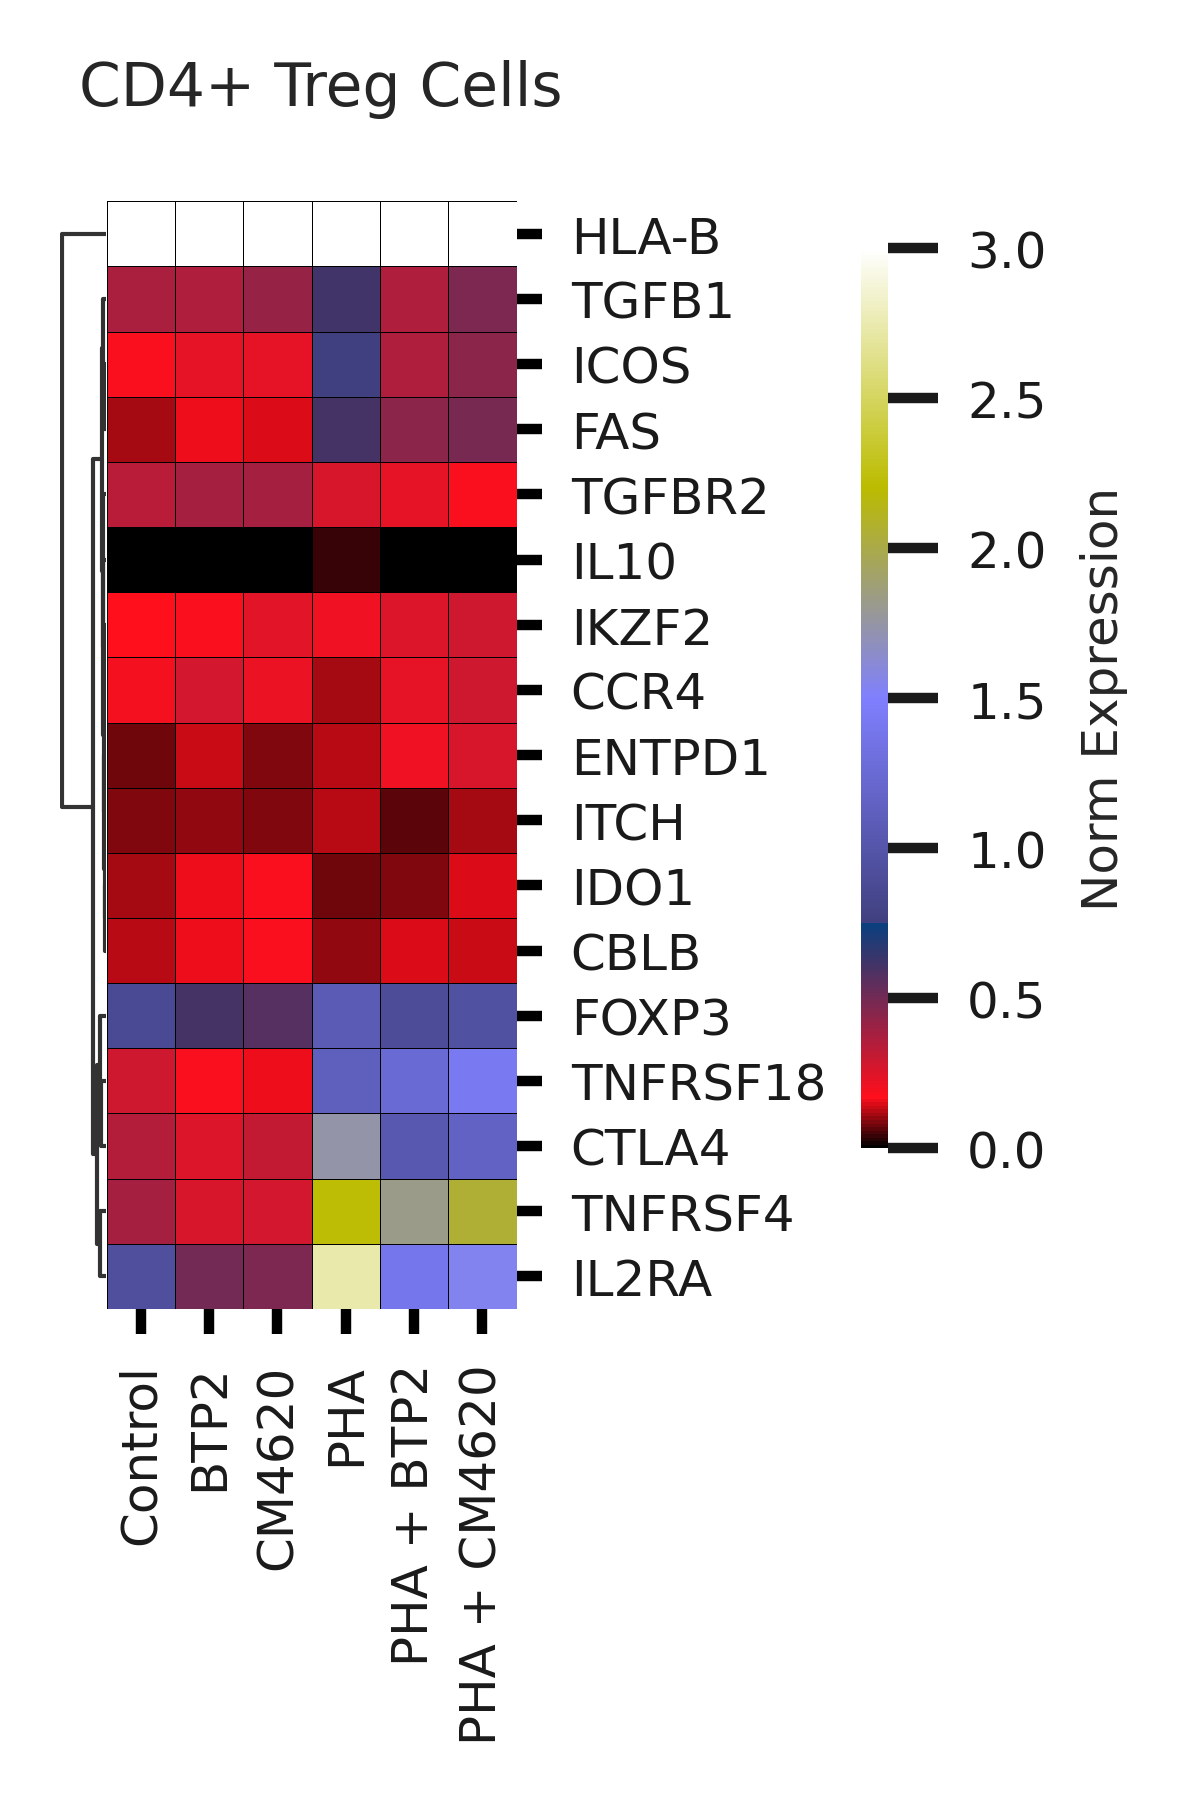

In [30]:

sc.set_figure_params(fontsize=6,dpi=300)

gene_list = common_genes

# Subset the data for CD8+ Effector T Cells
Treg_subset = adata[adata.obs['Broad_Manual_Anno_renamed'] == 'CD4+ Treg Cells']

# Initialize the ordered conditions
ordered_conditions = ['Control', 'BTP2', 'CM4620', 
                      'PHA', 'PHA + BTP2', 'PHA + CM4620']

# Initialize a DataFrame to store the average expression values by condition
avg_expression = pd.DataFrame(index=gene_list, columns=ordered_conditions)

# Calculate the average expression for each gene split by condition
for condition in ordered_conditions:
    # Subset the data for each condition
    condition_subset = Treg_subset[Treg_subset.obs['Condition'] == condition]
    
    # Convert to dense matrix if sparse
    condition_data = condition_subset[:, gene_list].X
    if not isinstance(condition_data, np.ndarray):
        condition_data = condition_data.toarray()  # Convert sparse matrix to dense matrix if needed
    
    # Calculate the mean expression for each gene and store it in the dataframe
    avg_expression[condition] = condition_data.mean(axis=0)

# Create a clustermap using seaborn
g = sns.clustermap(avg_expression, cmap="gist_stern", annot=False, cbar_kws={'label': 'Norm Expression'},col_cluster=False ,
               figsize=(1.5, 3), metric="euclidean", method="average",dendrogram_ratio=(0.1, 0.1),cbar_pos = (0.95,0.375,0.03,0.5),
                  linecolor='black', linewidths=0.1,vmin=0,vmax = 3)

g.ax_heatmap.tick_params(axis='x', which='both', bottom=True, top=False, length=3, color='black')
g.ax_heatmap.tick_params(axis='y', which='both', bottom=True, top=False, length=3, color='black')
g.fig.suptitle('CD4+ Treg Cells', 
               x=0.35) 
plt.savefig('Final_Notebooks/Figures/Marker_Prog/Tol_norm_gene_heatmap_Tregs.pdf', bbox_inches='tight', dpi=300)

plt.show()


### Generate Tolerance Module Scores

In [31]:
markers = common_genes
name_mark = "Tolerance"

In [32]:
sc.tl.score_genes(adata, markers, ctrl_size=200, gene_pool=None,
                  n_bins=25, score_name=name_mark, random_state=0, 
               copy=False, use_raw=None)

computing score 'Tolerance'
    finished: added
    'Tolerance', score of gene set (adata.obs).
    2197 total control genes are used. (0:00:03)


/tmp/ipykernel_3833847/1570049438.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_scores = df.groupby(['Condition', 'Broad_Manual_Anno_renamed']).mean().reset_index()


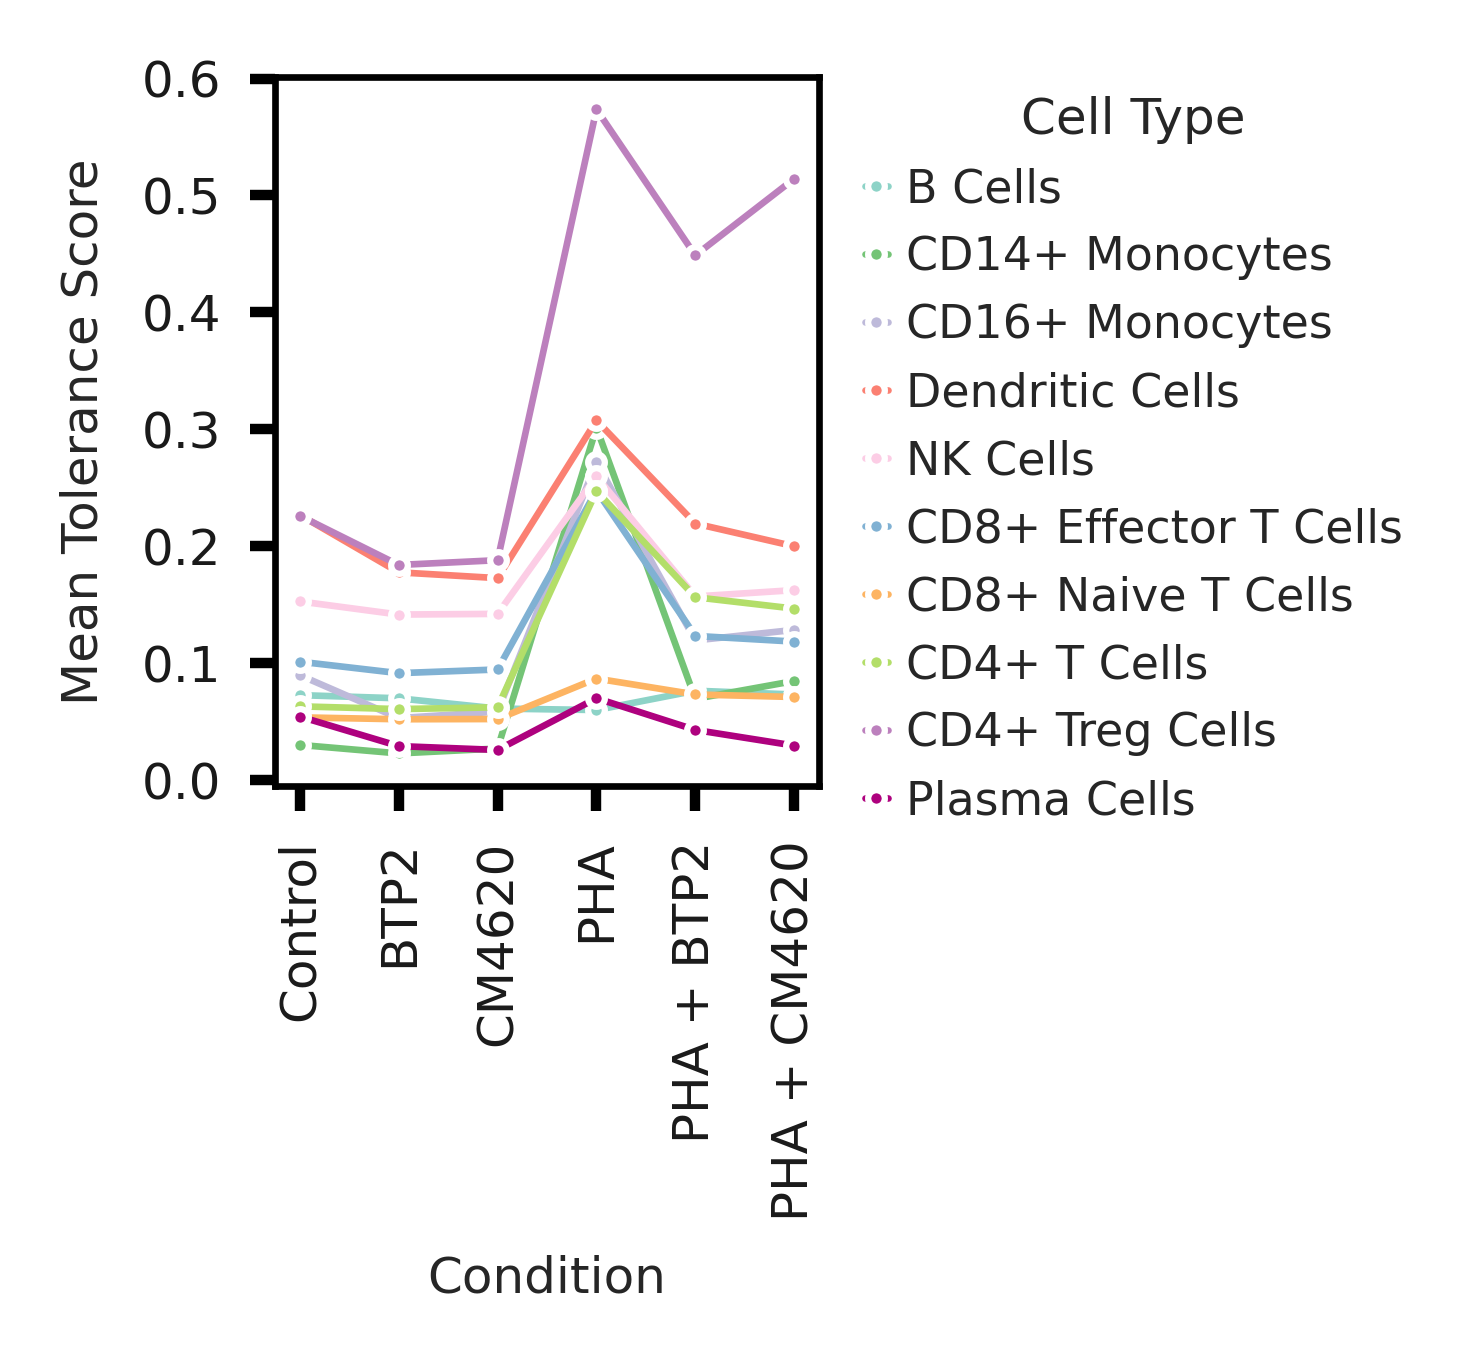

In [33]:
celltype_color_dict = {
    'B Cells': '#8dd3c7',
    'CD14+ Monocytes': '#74c476',
    'CD16+ Monocytes': '#bebada',
    'Dendritic Cells': '#fb8072',
    'CD8+ Effector T Cells': '#80b1d3',
    'CD8+ Naive T Cells': '#fdb462',
    'CD4+ T Cells': '#b3de69',
    'NK Cells': '#fccde5',
    'Plasma Cells': '#ae017e',
    'CD4+ Treg Cells': '#bc80bd'
}

df = adata.obs[['Condition', 'Broad_Manual_Anno_renamed', name_mark]]

# Calculate mean scores
mean_scores = df.groupby(['Condition', 'Broad_Manual_Anno_renamed']).mean().reset_index()

# Create a line plot
plt.figure(figsize=(2.5, 2.25),dpi=300)
sns.lineplot(data=mean_scores, x='Condition', y=name_mark, hue='Broad_Manual_Anno_renamed', marker='o', sort=True,
             palette=celltype_color_dict, linewidth=0.8,markersize=2)

# Add labels and title
plt.xlabel('Condition')
plt.ylabel(f'Mean {name_mark} Score')
plt.title(f'')#Mean {name_mark} Scores by Condition and Cell Type
plt.xticks(rotation=90,ha = "center")  # Rotating x labels for better readability
plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,frameon=False,title_fontsize=6)
plt.grid(False)
plt.tick_params(axis='x', which='both', bottom=True, top=False, length=3, color='black')
plt.tick_params(axis='y', which='both', left=True, right=False, length=3, color='black')
# Show the plot
plt.tight_layout()
plt.savefig('Final_Notebooks/Figures/Marker_Prog/tol_line_plot.pdf', bbox_inches='tight',dpi=300)
plt.show()


### Calculate Cohen's d metric for Tolerance

In [34]:
cell_type = "CD4+ Treg Cells"
module_name = name_mark
marker_data = adata


In [35]:
condition_palette =['#e78ac3','#ffd92f','#377eb8','#7570b3','#e41a1c','#4daf4a']


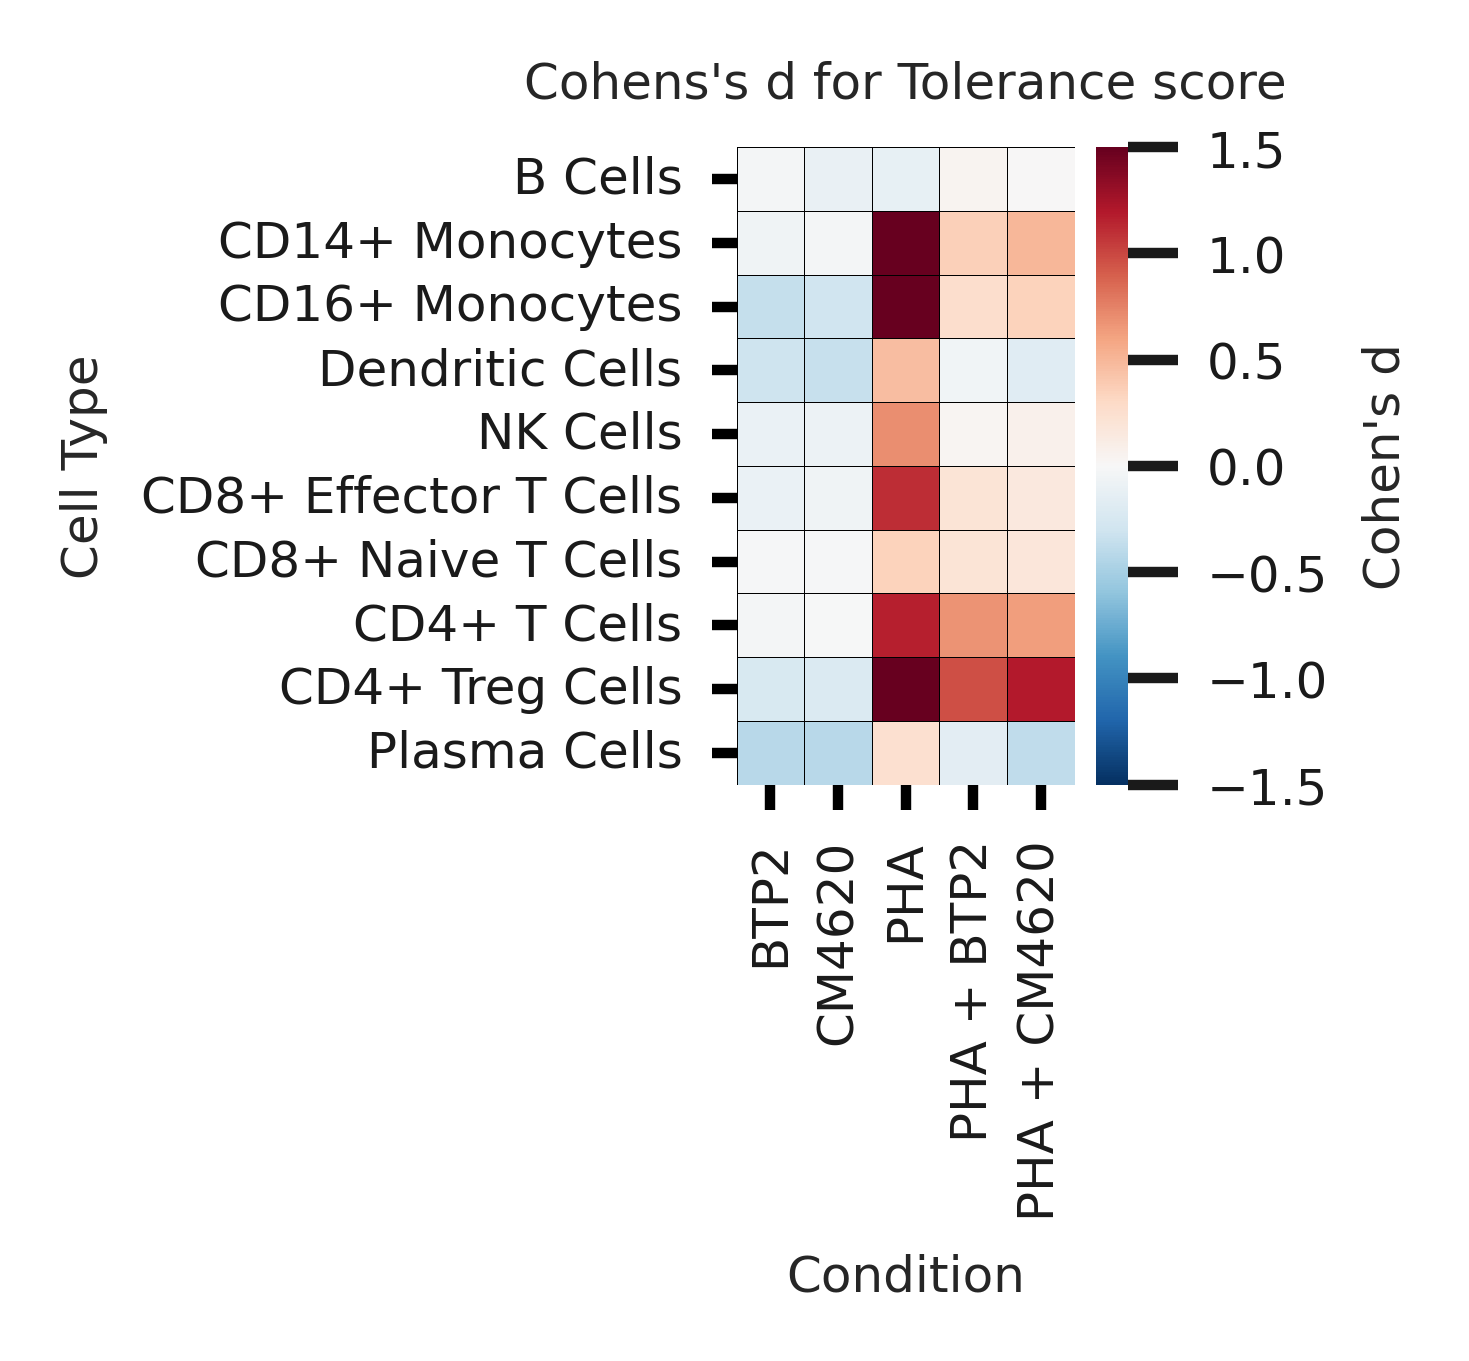

In [36]:
sns.set(style="white")
sc.set_figure_params(fontsize=6,dpi=300)

# Define a function to calculate Cohen's d
def cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    pooled_std = np.sqrt((np.var(x, ddof=1) * (nx - 1) + np.var(y, ddof=1) * (ny - 1)) / (nx + ny - 2))
    return (np.mean(x) - np.mean(y)) / pooled_std

# Get the specified order of conditions
ordered_conditions = ['BTP2', 'CM4620', 
                      'PHA', 'PHA + BTP2', 'PHA + CM4620']

# Desired order of cell types
celltype_order = ['B Cells', 'CD14+ Monocytes', 'CD16+ Monocytes', 'Dendritic Cells','NK Cells',
                  'CD8+ Effector T Cells', 'CD8+ Naive T Cells', 'CD4+ T Cells',
                    'CD4+ Treg Cells','Plasma Cells']

# Initialize a DataFrame to store Cohen's d values
cohen_d_matrix = pd.DataFrame(index=celltype_order, columns=ordered_conditions)

# Calculate Cohen's d for each cell type and condition compared to the control
control_condition = 'Control'
for cell_type in celltype_order:
    control_data = marker_data.obs[(marker_data.obs['Condition'] == control_condition) &
                                   (marker_data.obs['Broad_Manual_Anno_renamed'] == cell_type)][module_name]
    for condition in ordered_conditions:
        condition_data = marker_data.obs[(marker_data.obs['Condition'] == condition) &
                                         (marker_data.obs['Broad_Manual_Anno_renamed'] == cell_type)][module_name]
        if len(control_data) > 1 and len(condition_data) > 1:  # Ensure there is enough data to calculate Cohen's d
            cohen_d_matrix.loc[cell_type, condition] = cohens_d(condition_data, control_data)

# Plot the heatmap with adjusted scale limits
plt.figure(figsize=(2.3, 2.25))
sns.heatmap(cohen_d_matrix.astype(float), annot=False, fmt=".2f", cmap="RdBu_r", cbar_kws={'label': "Cohen's d"}, linecolor='black', linewidths=0.1, vmin=-1.5, vmax=1.5)
plt.title(f'Cohens\'s d for {module_name} score')
plt.xlabel('Condition')
plt.ylabel('Cell Type')
plt.xticks(rotation=90, ha='center')
plt.tick_params(axis='x', which='both', bottom=True, top=False, length=3, color='black')
plt.tick_params(axis='y', which='both', left=True, right=False, length=3, color='black')
plt.tight_layout()

# Save the figure
plt.savefig('Final_Notebooks/Figures/Marker_Prog/tol_heatmap.pdf', bbox_inches='tight', dpi=300)
plt.show()  # Display the plot


In [37]:
!pip list

Package                   Version
------------------------- --------------
adjustText                1.3.0
anndata                   0.10.9
anyio                     4.6.2.post1
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
array_api_compat          1.9.1
arrow                     1.3.0
asttokens                 2.4.1
async-lru                 2.0.4
attrs                     24.2.0
babel                     2.16.0
beautifulsoup4            4.12.3
bleach                    6.2.0
Brotli                    1.1.0
cached-property           1.5.2
certifi                   2024.8.30
cffi                      1.17.1
charset-normalizer        3.4.0
colorama                  0.4.6
comm                      0.2.2
contourpy                 1.3.0
cycler                    0.12.1
debugpy                   1.8.8
decorator                 5.1.1
defusedxml                0.7.1
entrypoints               0.4
et_xmlfile                2.0.0
exceptiongroup            1.2.2
executing    